In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
train_transform = transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

In [3]:
root = '../data/kaggle_train_128/'

train_data = datasets.ImageFolder(os.path.join(root, 'train_128'), transform=train_transform)
torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
class_names = train_data.classes
print(class_names)
print(f'Training images available: {len(train_data)}')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

['0', '1', '2', '3', '4']
Training images available: 15000


Label: [0 2 3 2 1 3 4 2 4 0]
Class: 0 2 3 2 1 3 4 2 4 0


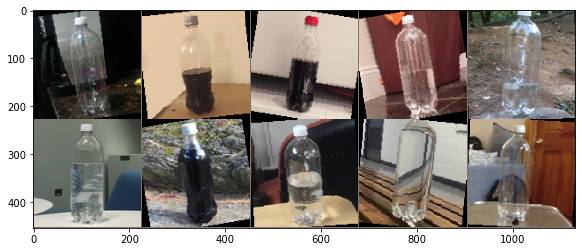

In [4]:
# Grab the first batch of 10 images
for images,labels in train_loader: 
    break

# Print the labels
print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=5)  # the default nrow is 8

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

In [5]:
Googlenet = models.vgg16(pretrained=True,progress=True)
Googlenet

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\amogh/.cache\torch\checkpoints\vgg16-397923af.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [12]:
for param in Googlenet.parameters():
    param.requires_grad = False

In [17]:
torch.manual_seed(42)
Googlenet.classifier = nn.Sequential(nn.Linear(25088, 4096),
                                 nn.ReLU(inplace=True),
                                 nn.Dropout(0.5),
                                 nn.Linear(4096, 4096),
                                 nn.ReLU(inplace=True),
                                 nn.Dropout(0.5),
                                 nn.Linear(4096,1000),
                                 nn.ReLU(inplace=True),
                                 nn.Dropout(0.5),
                                 nn.Linear(1000,5),
                                 nn.LogSoftmax(dim=1)).cuda()
Googlenet.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [18]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')

In [19]:
count_parameters(Googlenet)

102760448
    4096
16777216
    4096
 4096000
    1000
    5000
       5
________
123647861


In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(Googlenet.fc.parameters(), lr=0.001)

In [ ]:
# AlexNetmodel = AlexNetmodel.to(device)
import time
start_time = time.time()

epochs = 5

max_trn_batch = 800
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
#         if b == max_trn_batch:
#             break
        b+=1
        
        # Apply the model
        X_train = X_train.cuda()
        y_train = y_train.cuda()
        y_pred = Googlenet(X_train)
        
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    
#         Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}\
            accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

#     # Run the testing batches
#     with torch.no_grad():
#         for b, (X_test, y_test) in enumerate(test_loader):
#             if b == max_tst_batch:
#                 break

#             # Apply the model
#             y_val = AlexNetmodel(X_test)

#             # Tally the number of correct predictions
#             predicted = torch.max(y_val.data, 1)[1] 
#             tst_corr += (predicted == y_test).sum()

#     loss = criterion(y_val, y_test)
#     test_losses.append(loss)
#     test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:  200 [  2000/8000]  loss: 1.63666272            accuracy:  19.500%
epoch:  0  batch:  400 [  4000/8000]  loss: 1.61641622            accuracy:  19.800%
